In [29]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import seaborn as sns 


In [30]:
df1 = pd.read_csv('df1.csv')

In [31]:
df1

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,Quantity
0,0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,1
1,1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2
2,2,2019-10-01 00:09:54,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,2
3,3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,1
4,4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,1
...,...,...,...,...,...,...,...,...,...,...,...
1208758,1208758,2019-11-30 23:58:57,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,235.60,579876821,ca50e291-43f3-4ca2-9e13-20ee6b8b25f0,2
1208759,1208759,2019-11-30 23:57:23,purchase,1005212,2053013555631882655,electronics.smartphone,samsung,169.09,557794415,068b0939-1d19-4289-90d8-bb0ee2a3547a,1
1208760,1208760,2019-11-30 23:58:08,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,235.60,574868869,878a1538-ebe3-4d7f-b773-1b057b1971eb,1
1208761,1208761,2019-11-30 23:58:22,purchase,1005130,2053013555631882655,electronics.smartphone,apple,1437.02,515582054,829c20b5-696e-4a8a-8a9f-171014a3ecbe,1


In [33]:
df1['event_time'] = df1['event_time'].apply(lambda x: x[:-4])
df1['event_time'] = pd.to_datetime(df1['event_time'], format='%Y-%m-%d %H:%M:%S')

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208763 entries, 0 to 1208762
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Unnamed: 0     1208763 non-null  int64         
 1   event_time     1208763 non-null  datetime64[ns]
 2   event_type     1208763 non-null  object        
 3   product_id     1208763 non-null  int64         
 4   category_id    1208763 non-null  int64         
 5   category_code  1208763 non-null  object        
 6   brand          1208763 non-null  object        
 7   price          1208763 non-null  float64       
 8   user_id        1208763 non-null  int64         
 9   user_session   1208763 non-null  object        
 10  Quantity       1208763 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 101.4+ MB


### Customer Lifetime Value (Müşteri Yaşam Boyu Değeri)
--> Bir müşterinin şirket ile ilişki içerisinde bulunduğu sürece şirkete kazandırdığı toplam parasal değer.


In [4]:
def create_cltv_c(df1, profit=0.10):

    # Veriyi hazırlama
    df1 = df1[(df1['Quantity'] > 0)]
    df1.dropna(inplace=True)
    df1["total_price"] = df1["Quantity"] * df1["price"]
    cltv_c = df1.groupby('user_id').agg({'user_session': lambda x: x.nunique(),
                                                   'Quantity': lambda x: x.sum(),
                                                   'total_price': lambda x: x.sum()})
    cltv_c.columns = ['total_transaction', 'total_unit', 'total_price']
    # avg_order_value
    cltv_c['avg_order_value'] = cltv_c['total_price'] / cltv_c['total_transaction']
    # purchase_frequency
    cltv_c["purchase_frequency"] = cltv_c['total_transaction'] / cltv_c.shape[0]
    # repeat rate & churn rate
    repeat_rate = cltv_c[cltv_c.total_transaction > 1].shape[0] / cltv_c.shape[0]
    churn_rate = 1 - repeat_rate
    # profit_margin
    cltv_c['profit_margin'] = cltv_c['total_price'] * profit
    # Customer Value
    cltv_c['customer_value'] = (cltv_c['avg_order_value'] * cltv_c["purchase_frequency"])
    # Customer Lifetime Value
    cltv_c['cltv'] = (cltv_c['customer_value'] / churn_rate) * cltv_c['profit_margin']
    # Segment
    cltv_c["segment"] = pd.qcut(cltv_c["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_c


df_ = df1.copy()

clv = create_cltv_c(df_)

In [5]:
clv

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
user_id,,,,,,,,,
225644257,1,1,40.91,40.91,0.000002,4.091,0.000077,0.000476,D
253299396,1,1,246.85,246.85,0.000002,24.685,0.000463,0.017319,C
256164170,1,1,113.23,113.23,0.000002,11.323,0.000212,0.003644,D
296197073,1,1,51.46,51.46,0.000002,5.146,0.000096,0.000753,D
299358698,1,1,154.19,154.19,0.000002,15.419,0.000289,0.006757,D
...,...,...,...,...,...,...,...,...,...
579962677,1,1,1634.38,1634.38,0.000002,163.438,0.003063,0.759195,A
579963523,1,1,457.91,457.91,0.000002,45.791,0.000858,0.059595,B
579964521,1,1,334.60,334.60,0.000002,33.460,0.000627,0.031820,B


In [6]:
clv.reset_index(inplace=True)

In [7]:
clv

,user_id,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,customer_value,cltv,segment
0,225644257,1,1,40.91,40.91,0.000002,4.091,0.000077,0.000476,D
1,253299396,1,1,246.85,246.85,0.000002,24.685,0.000463,0.017319,C
2,256164170,1,1,113.23,113.23,0.000002,11.323,0.000212,0.003644,D
3,296197073,1,1,51.46,51.46,0.000002,5.146,0.000096,0.000753,D
4,299358698,1,1,154.19,154.19,0.000002,15.419,0.000289,0.006757,D
...,...,...,...,...,...,...,...,...,...,...
533567,579962677,1,1,1634.38,1634.38,0.000002,163.438,0.003063,0.759195,A
533568,579963523,1,1,457.91,457.91,0.000002,45.791,0.000858,0.059595,B
533569,579964521,1,1,334.60,334.60,0.000002,33.460,0.000627,0.031820,B
533570,579966375,1,1,124.11,124.11,0.000002,12.411,0.000233,0.004378,D


In [8]:
#clv.describe().T

In [9]:
clv.describe().apply(lambda s: s.apply('{0:.5f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
user_id,533572.00000,540664509.48999,21434689.59778,225644257.00000,518628873.25000,541126158.00000,560173273.50000,579967058.00000
total_transaction,533572.00000,1.92154,2.87613,1.00000,1.00000,1.00000,2.00000,328.00000
total_unit,533572.00000,3.40757,25.84803,1.00000,1.00000,1.00000,2.00000,9031.00000
total_price,533572.00000,1298.54874,14189.55959,0.87000,154.91250,333.32000,922.43000,7378819.86000
avg_order_value,533572.00000,515.81399,1692.78055,0.87000,133.41458,246.52000,558.46938,871517.30667
purchase_frequency,533572.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00061
profit_margin,533572.00000,129.85487,1418.95596,0.08700,15.49125,33.33200,92.24300,737881.98600
customer_value,533572.00000,0.00243,0.02659,0.00000,0.00029,0.00062,0.00173,13.82910
cltv,533572.00000,57.70407,21625.09370,0.00000,0.00682,0.03158,0.24183,15474662.92819


<AxesSubplot:xlabel='segment', ylabel='count'>

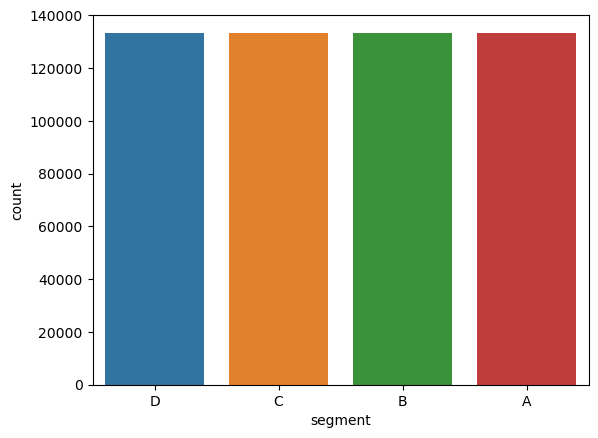

In [10]:
sns.countplot(x="segment", data=clv)

In [11]:
clv['segment'].value_counts()

C    133395
D    133393
A    133393
B    133391
Name: segment, dtype: int64

-------

In [12]:
#!pip install lifetimes

In [13]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [37]:
today_date = dt.datetime(2019, 12, 3)

In [38]:
cltv_df = df1.groupby('user_id').agg(
    {'event_time': [lambda event_time: (event_time.max() - event_time.min()).days,
                     lambda event_time: (today_date - event_time.min()).days],
     'user_session': lambda user_session: user_session.nunique(),
     'price': lambda price: price.sum()})

In [39]:
cltv_df.head()

event_time            user_session    price
          <lambda_0> <lambda_1>     <lambda> <lambda>
user_id                                              
225644257          0         20            1    40.91
253299396          0         26            1   246.85
256164170          0         12            1   113.23
296197073          0          2            1    51.46
299358698          0         23            1   154.19

In [40]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [41]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
user_id,,,,
225644257,0,20,1,40.91
253299396,0,26,1,246.85
256164170,0,12,1,113.23
296197073,0,2,1,51.46
299358698,0,23,1,154.19


In [43]:
cltv_df.columns = ['recency', 'T','frequency', 'monetary']

In [44]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [45]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [46]:
cltv_df["recency"] = cltv_df["recency"] / 7

In [47]:
cltv_df["T"] = cltv_df["T"] / 7

In [68]:
bgf = BetaGeoFitter(penalizer_coef=0.6)
bgf.fit(cltv_df['frequency'],
cltv_df['recency'],
cltv_df['T'])

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in su

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

      fun: nan
 hess_inv: array([[ 20.60411379,  82.81470709,   5.69436095,   6.7043704 ],
       [ 82.81470709, 338.34902948,  23.08379692,  27.78379857],
       [  5.69436095,  23.08379692,   2.43125883,   1.9258068 ],
       [  6.7043704 ,  27.78379857,   1.9258068 ,   2.81874904]])
      jac: array([nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 119
      nit: 7
     njev: 119
   status: 2
  success: False
        x: array([-12720.53730834, -52552.13641769,  -3543.46170211,  -4248.85145192])


/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in mul

ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


In [58]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in su

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

      fun: nan
 hess_inv: array([[ 6.69412961e+01,  2.30486486e+02, -1.54487776e+00,
         5.91294987e+00],
       [ 2.30486486e+02,  8.04711869e+02, -4.62726731e+00,
         2.30016922e+01],
       [-1.54487776e+00, -4.62726731e+00,  4.00379507e-01,
         4.06662269e-01],
       [ 5.91294987e+00,  2.30016922e+01,  4.06662269e-01,
         2.09544970e+00]])
      jac: array([nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 126
      nit: 13
     njev: 126
   status: 2
  success: False
        x: array([-2.36193081e+04, -8.39294043e+04, -5.25240989e+01, -2.88001840e+03])


/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/necibecan/opt/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: Runtim

ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


------

In [57]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
cltv_df['frequency'],
cltv_df['recency'],
cltv_df['T']).sort_values(ascending=False).head(10)

ValueError: Model has not been fit yet. Please call the .fit method first.

In [56]:
bgf.predict(1,
cltv_df['frequency'],
cltv_df['recency'],
cltv_df['T']).sort_values(ascending=False).head(10)

AttributeError: 'BetaGeoFitter' object has no attribute 'predict'

In [53]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
cltv_df['frequency'],
cltv_df['recency'],
cltv_df['T'])

AttributeError: 'BetaGeoFitter' object has no attribute 'predict'

In [ ]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

In [ ]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

In [ ]:
cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])